# Pix2Pix란?

앞선 DCGAN에선 가우시안 정규 분포의 노이즈를 삽입하여 이미지를 생성.

pix2pix는 원본 이미지를 넣으면 그에 상응하는 출력 이미지를 생성.

즉 , 기존 GAN은 판별기가 하나의 이미지가 True or False인지 분류했다면 Pix2Pix는 한쌍의 이미지를 넣고 True of False분류.

한쌍의 이미지는 (진짜이미지 , 대응하는 진짜이미지) / (진짜이미지 , 생성된 이미지)

# Pix2Pix의 생성기는 Unet을 사용한다.

Unet이란? 

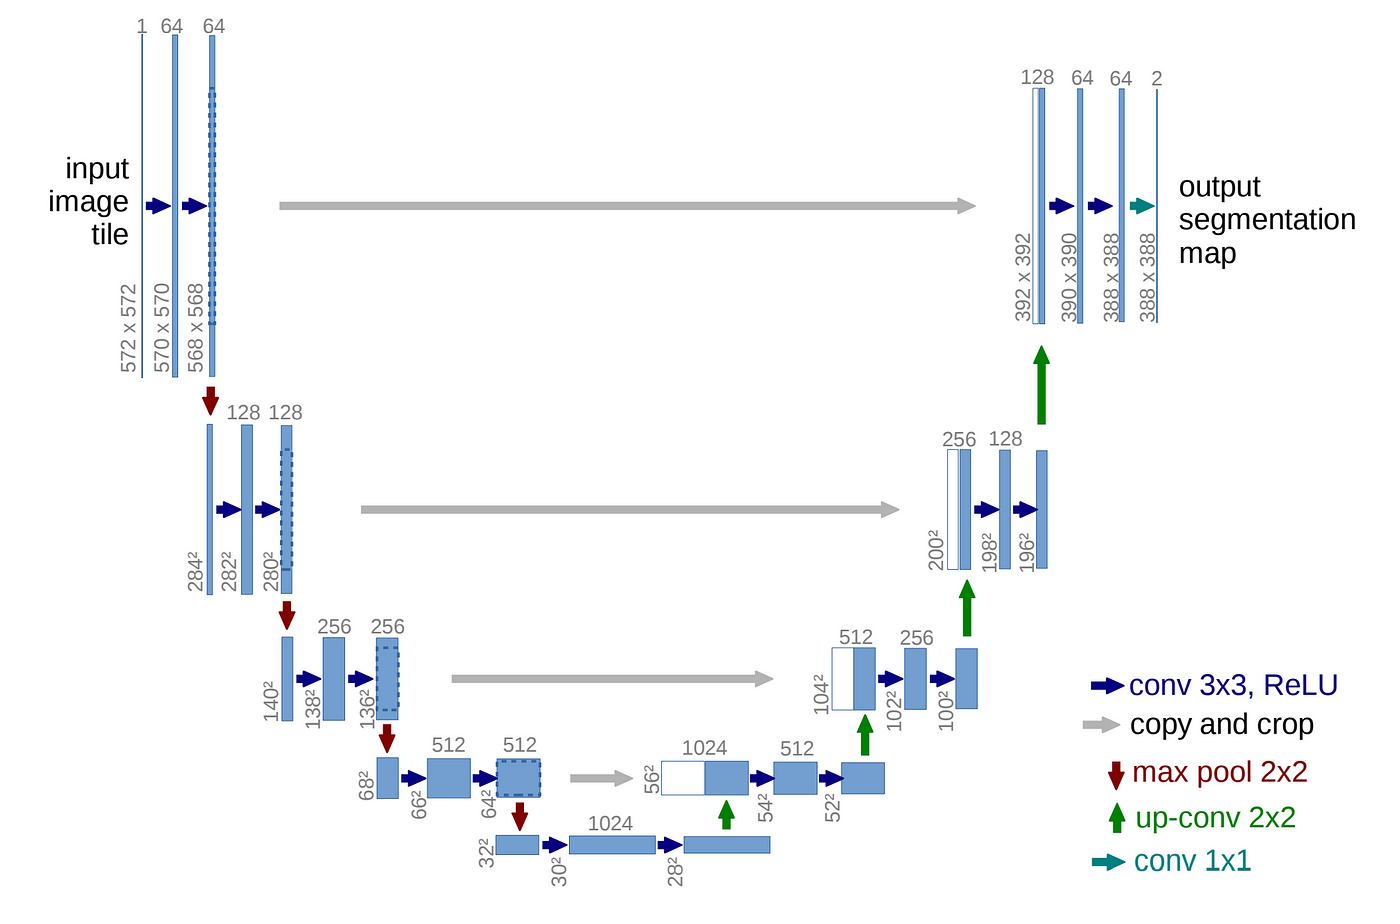

Unet의 효과 - 원본 이미지를 잘 파악하고 원하는대로 만들 수 있다. (인코더 디코더 구조)

Unet vs AutoEncoder?

Unet은 Skip-connection으로 고차원 정보를 사용하여 Upsampling을 진행함.

반면 AutoEncoder는 그런 과정이 없음. latent vector만을 사용하여 Upsampling을 진행해아햠. (즉, Skip connection의 유무)

In [11]:
# 패키지 임포트

import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable


import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from tqdm import tqdm

ConvTranspose2d : 늘린 상태에서 CNN 적용

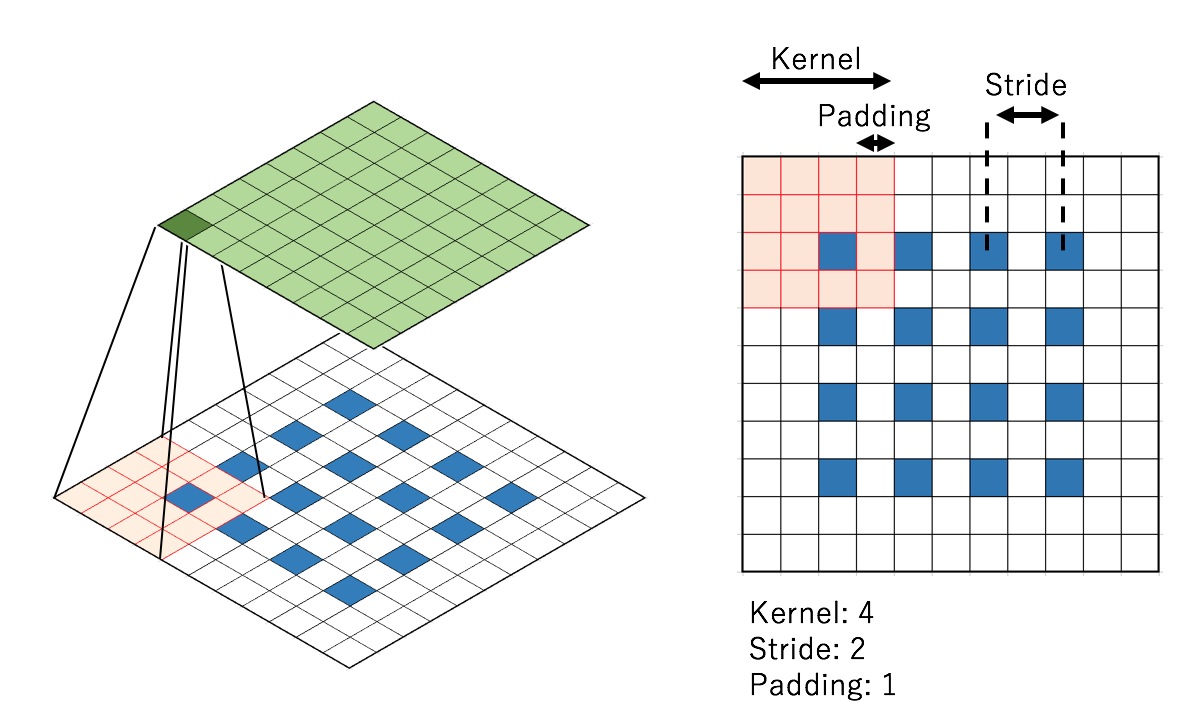

Blue - input , cyan - outputs



https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md 참고

In [13]:
class UpConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz, dropout=0.0): 
        super(UpConvBlock, self).__init__()
        self.layers = [
            nn.ConvTranspose2d(ip_sz, op_sz, 4, 2, 1),  # in_c , out_c , kernel_size , stride , padding
            # 커널이 4이므로 4배증가 , stride가 2 이므로 1/2배
            nn.InstanceNorm2d(op_sz),
            nn.ReLU(),
        ]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
    def forward(self, x, enc_ip):
        x = nn.Sequential(*(self.layers))(x)
        op = torch.cat((x, enc_ip), 1)  # UNet의 Skip connection 부분 , 채널에 concat
        return op

In [14]:
class DownConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz, norm=True, dropout=0.0):
        super(DownConvBlock, self).__init__()
        self.layers = [nn.Conv2d(ip_sz, op_sz, 4, 2, 1)]
        if norm:
            self.layers.append(nn.InstanceNorm2d(op_sz))
        self.layers += [nn.LeakyReLU(0.2)]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
    def forward(self, x):
        op = nn.Sequential(*(self.layers))(x)
        return op

In [15]:
class UNetGenerator(nn.Module):
    def __init__(self, chnls_in=3, chnls_op=3):
        super(UNetGenerator, self).__init__()
        self.down_conv_layer_1 = DownConvBlock(chnls_in, 64, norm=False)
        self.down_conv_layer_2 = DownConvBlock(64, 128)
        self.down_conv_layer_3 = DownConvBlock(128, 256)
        self.down_conv_layer_4 = DownConvBlock(256, 512, dropout=0.5)
        self.down_conv_layer_5 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer_6 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer_7 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer_8 = DownConvBlock(512, 512, norm=False, dropout=0.5)

        self.up_conv_layer_1 = UpConvBlock(512, 512, dropout=0.5)
        self.up_conv_layer_2 = UpConvBlock(1024, 512, dropout=0.5)
        self.up_conv_layer_3 = UpConvBlock(1024, 512, dropout=0.5)
        self.up_conv_layer_4 = UpConvBlock(1024, 512, dropout=0.5)
        self.up_conv_layer_5 = UpConvBlock(1024, 256)
        self.up_conv_layer_6 = UpConvBlock(512, 128)
        self.up_conv_layer_7 = UpConvBlock(256, 64)
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))  # 순서대로 left , right , top , bottom
        self.conv_layer_1 = nn.Conv2d(128, chnls_op, 4, padding=1)
        self.activation = nn.Tanh()
        
    def forward(self, x):
        enc1 = self.down_conv_layer_1(x)
        enc2 = self.down_conv_layer_2(enc1)
        enc3 = self.down_conv_layer_3(enc2)
        enc4 = self.down_conv_layer_4(enc3)
        enc5 = self.down_conv_layer_5(enc4)
        enc6 = self.down_conv_layer_6(enc5)
        enc7 = self.down_conv_layer_7(enc6)
        enc8 = self.down_conv_layer_8(enc7)
        dec1 = self.up_conv_layer_1(enc8, enc7)
        dec2 = self.up_conv_layer_2(dec1, enc6)
        dec3 = self.up_conv_layer_3(dec2, enc5)
        dec4 = self.up_conv_layer_4(dec3, enc4)
        dec5 = self.up_conv_layer_5(dec4, enc3)
        dec6 = self.up_conv_layer_6(dec5, enc2)
        dec7 = self.up_conv_layer_7(dec6, enc1)
        final = self.upsample_layer(dec7)
        final = self.zero_pad(final)
        final = self.conv_layer_1(final)
        return self.activation(final)

In [16]:
class Pix2PixDiscriminator(nn.Module):
    def __init__(self, chnls_in=3):
        super(Pix2PixDiscriminator, self).__init__()
        def disc_conv_block(chnls_in, chnls_op, norm=1):
            layers = [nn.Conv2d(chnls_in, chnls_op, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(chnls_op))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.lyr1 = disc_conv_block(chnls_in * 2, 64, norm=0)   # 실제 이미지 , (생성 or 쌍 이미지) 채널에서 concat
        self.lyr2 = disc_conv_block(64, 128)
        self.lyr3 = disc_conv_block(128, 256)
        self.lyr4 = disc_conv_block(256, 512)
        
    def forward(self, real_image, translated_image):
        ip = torch.cat((real_image, translated_image), 1)
        op = self.lyr1(ip)
        op = self.lyr2(op)
        op = self.lyr3(op)
        op = self.lyr4(op)
        op = nn.ZeroPad2d((1, 0, 1, 0))(op)
        op = nn.Conv2d(512, 1, 4, padding=1)(op)
        return op